# Imports and project setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib import colors, cm
import glob
from datetime import datetime, timedelta

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union, List

import hoomd
import gsd.hoomd
import freud
import schmeud
from schmeud._schmeud import dynamics as schmeud_dynamics

import sys
import time
import pickle
import gc
import warnings
import copy
import pathlib
from collections import defaultdict

import os
import sys

import signac

from dataclasses import dataclass
from dataclasses_json import dataclass_json

import fresnel
import PIL.Image

In [3]:
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["axes.labelsize"] = "x-large"

In [4]:
from monk import nb, prep, pair, render, utils, workflow, grid

config = workflow.get_config()

In [5]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'ref_sim_temps': [0.41, 0.43, 0.45, 0.47, 0.49, 0.51, 0.53, 0.55, 0.58, 0.61, 0.64, 0.67, 0.7, 0.75, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0], 'avail_seed': 18, 'alpha_iters': 40, 'dt': 0.001, 'usteps': 1000, '_status': {}}

# Table 1 - softness hyperplane info

1. Accuracies 

In [6]:

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)

    with open(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_ss-0_ts-10.pickle"), "rb") as f:
        pipeline = pickle.load(f)
    pipe = pipeline["pipe"]

    temps = set()

    job0 = jobs[0]
    
    
    for file0 in sorted(glob.glob(job0.fn("short_runs/temp-*/sfs.parquet"))):
        temp = utils.extract_between(file0, "temp-", "/sfs.parquet")
        dfs = []
        for job in jobs:
            file = sorted(glob.glob(job.fn(f"short_runs/temp-{temp}/sfs.parquet")))[0]
            # temps.add(temp)
            df = pd.read_parquet(file)
            df = df[df["type"] == 0]
            df["softness"] = pipe.decision_function(list(df["sf"]))
            df["rearrang"] = df["phop"] > 0.2
            df = df[df["rearrang"] == True]
            df["soft"] = df["softness"] > 0.0
            dfs.append(df)

            # mean_softs[temp].append(mean_softness)
            # break
            # break
            # break
        df = pd.concat(dfs)
        print(temp, df["soft"].mean())

    

0.0
0.45 0.7504835589941973
0.47 0.7786640079760718
0.49 0.7010526315789474
0.51 0.6740764955867931
0.53 0.6488654147104851
0.55 0.6101694915254238
0.58 0.5652599458805918
0.61 0.5290681787129389
0.64 0.49008410341605235
0.67 0.4742566709021601


IndexError: list index out of range

In [23]:
glob.glob(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_*.pickle"))

['/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-2_ts-12.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-1_ts-12.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-0_ts-11.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-2_ts-10.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-0_ts-12.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-1_ts-11.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-2_ts-11.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-1_ts-10.pickle',
 '/media/ian/Data2/monk/mlj-production/softness_pipelines/delta-0.4/pipe_ss-0_ts-10.pickle']

In [24]:

for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):

    print(delta)

    jobs = list(jobs_iter)
    for pipe_file in glob.glob(project.fn(f"softness_pipelines/delta-{delta:.1f}/pipe_*.pickle")):

        with open(pipe_file, "rb") as f:
            pipeline = pickle.load(f)
        pipe = pipeline["pipe"]

        temps = set()

        job0 = jobs[0]
        dfs = []
        for job in jobs:
            for file in sorted(glob.glob(job.fn("short_runs/temp-*/sfs.parquet")))[1:2]:
                temp = float(utils.extract_between(file, "temp-", "/sfs.parquet"))
                # temps.add(temp)
                df = pd.read_parquet(file)
                df = df[df["type"] == 0]
                df["softness"] = pipe.decision_function(list(df["sf"]))
                df["rearrang"] = df["phop"] > 0.2
                df = df[df["rearrang"] == True]
                df["soft"] = df["softness"] > 0.0
                dfs.append(df)
        df = pd.concat(dfs)
        print(temp, df["soft"].mean())

    

0.0
0.47 0.7796610169491526
0.47 0.7836490528414756
0.47 0.7756729810568295
0.47 0.769690927218345
0.47 0.773678963110668
0.47 0.7796610169491526
0.47 0.7716849451645065
0.47 0.7746759720837487
0.47 0.7786640079760718
0.1
0.59 0.7455705173635719
0.59 0.7455705173635719
0.59 0.742735648476258
0.59 0.7476966690290574
0.59 0.7377746279234585
0.59 0.7512402551381998
0.59 0.741318214032601
0.59 0.744153082919915
0.59 0.742735648476258
0.2
0.76 0.7549516351911562
0.76 0.7498848456932289
0.76 0.7521879318286504
0.76 0.7526485490557346
0.76 0.751727314601566
0.76 0.7535697835099032
0.76 0.7512666973744818
0.76 0.751727314601566
0.76 0.753109166282819
0.3
1.03 0.7089378990133488
1.03 0.7106790481717934
1.03 0.7159024956471272
1.03 0.7127103888566454
1.03 0.7190946024376088
1.03 0.7179338363319792
1.03 0.7153221125943122
1.03 0.7138711549622752
1.03 0.7167730702263494
0.4
1.48 0.7101193971422979
1.48 0.7112937952632609
1.48 0.712468193384224
1.48 0.7116852613035819
1.48 0.7138383245253475
1.48 0

# Origin of $\sigma'$ scaling?

In [103]:
@njit
def mlj_pot(r, delta, epsilon=1.0, sigma=1.0):
    dsigma = sigma*(1.0 - delta*2**(-1/6))
    lj1 = 4*epsilon*dsigma**12
    lj2 = 4*epsilon*dsigma**6
    inv_r = 1/(r-delta)
    inv_r2 = inv_r*inv_r
    inv_r6 = inv_r2*inv_r2*inv_r2
    return lj1*inv_r6*inv_r6 - lj2*inv_r6

@njit
def mlj_force(r, delta, epsilon=1.0, sigma=1.0):
    dsigma = sigma*(1.0 - delta*2**(-1/6))
    lj1 = 4*epsilon*12.0*dsigma**12
    lj2 = 4*epsilon*6.0*dsigma**6
    inv_r = 1/(r-delta)
    inv_r2 = inv_r*inv_r
    inv_r6 = inv_r2*inv_r2*inv_r2
    return lj1*inv_r6*inv_r6*inv_r - lj2*inv_r6*inv_r

@njit
def mlj_stiffness(r, delta, epsilon=1.0, sigma=1.0):
    dsigma = sigma*(1.0 - delta*2**(-1/6))
    lj1 = 4*epsilon*12.0*13.0*dsigma**12
    lj2 = 4*epsilon*6.0*7.0*dsigma**6
    inv_r = 1/(r-delta)
    inv_r2 = inv_r*inv_r
    inv_r6 = inv_r2*inv_r2*inv_r2
    return lj1*inv_r6*inv_r6*inv_r2 - lj2*inv_r6*inv_r2

Text(0, 0.5, '$V(r),F(r)$')

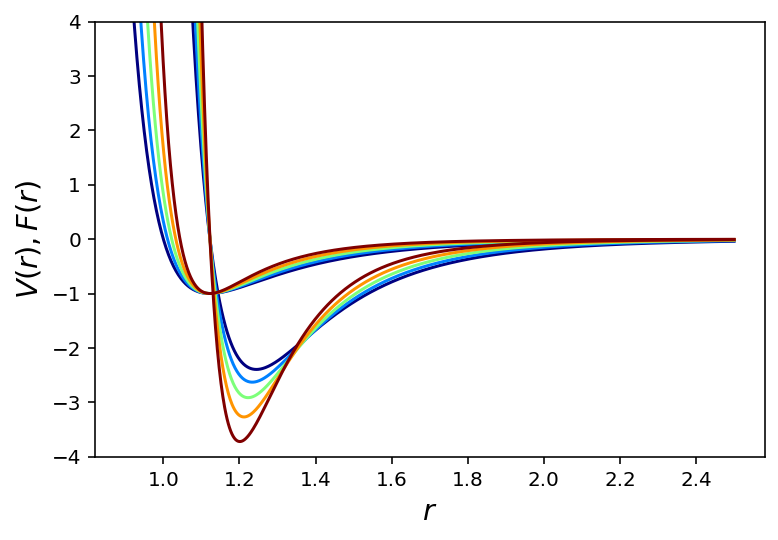

In [43]:
r = np.linspace(0.9, 2.5, 1000)
plt.ylim(-4, 4)
cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.4)
for delta in np.linspace(0.0, 0.4, 5):
    plt.plot(r, mlj_pot(r, delta), color=cmap(norm(delta)))
    plt.plot(r, mlj_force(r, delta), color=cmap(norm(delta)))

plt.xlabel(r"$r$")
plt.ylabel(r"$V(r),F(r)$")

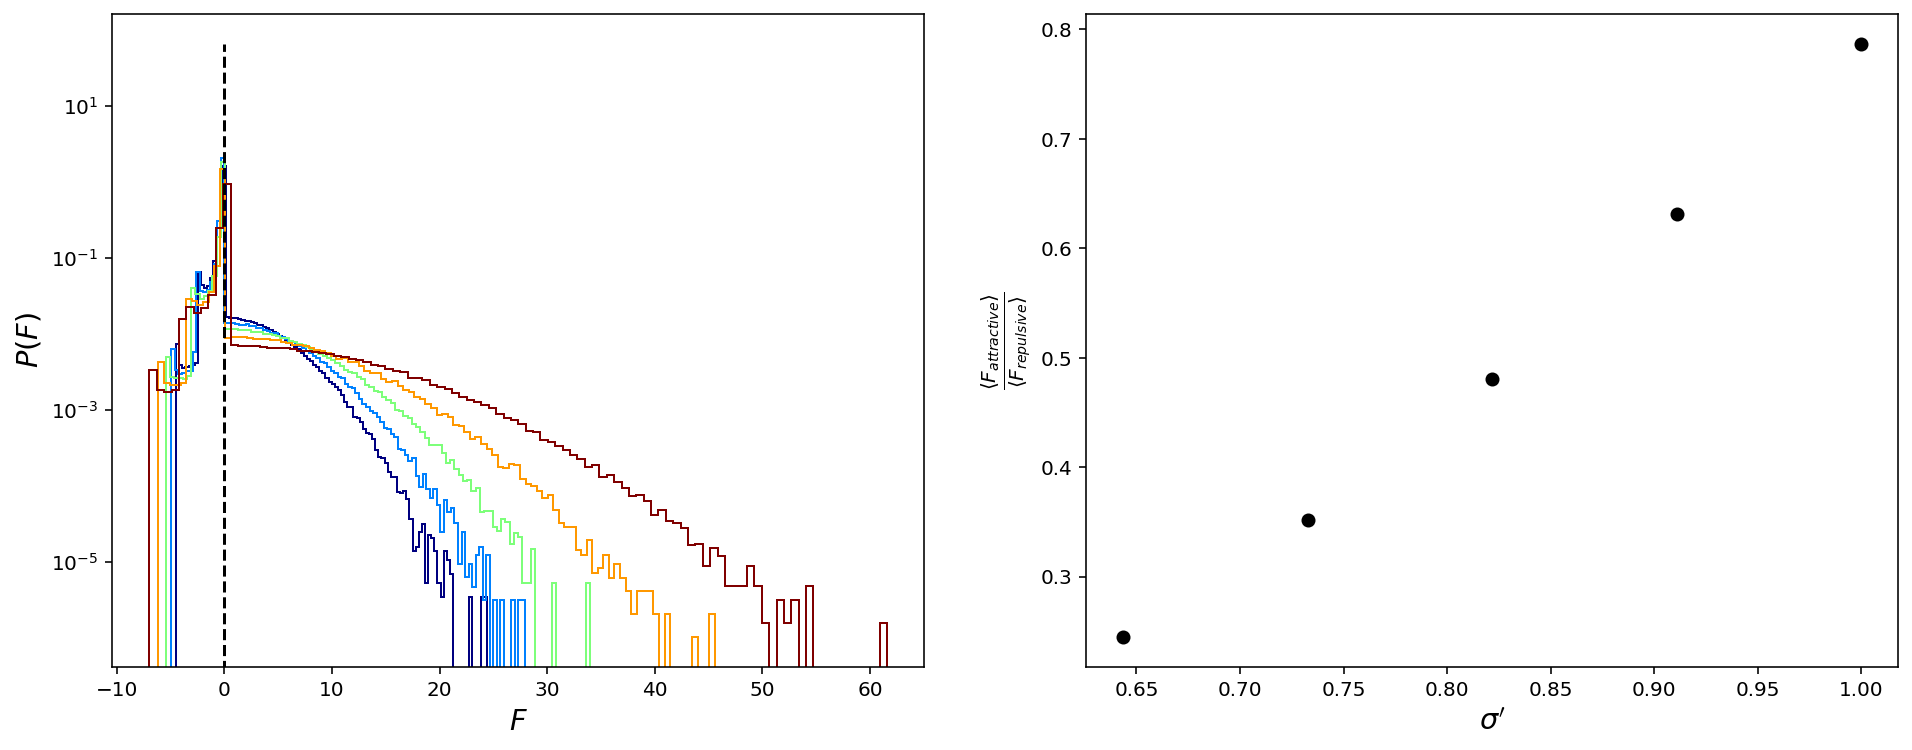

In [135]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.4)
data = []
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job = jobs_iter.__next__()
    for file in sorted(glob.glob(job.fn("short_runs/temp-*/fire_traj.gsd")))[2:3]:
        traj = gsd.hoomd.open(file)
        snap = traj[0]
        typeid = snap.particles.typeid
        position = snap.particles.position
        nlist_query = freud.locality.AABBQuery.from_system(snap)
        nlist = nlist_query.query(position[typeid == 0], {"r_min": 0.1, "r_max": 2.5}).toNeighborList()
        forces = np.zeros_like(nlist.distances)
        # energies = np.zeros_like(nlist.distances)
        plt.sca(axs[0])
        cond = typeid[nlist.point_indices] == 0
        forces[cond] = mlj_force(nlist.distances[cond], delta)#*nlist.distances[cond]
        cond = typeid[nlist.point_indices] == 1
        forces[cond] = mlj_force(nlist.distances[cond], delta, epsilon=1.5, sigma=0.8)#*nlist.distances[cond]
        plt.hist(forces, bins=100, histtype="step", density=True, label=f"{delta:.1f}", color=cmap(norm(delta)))
        plt.sca(axs[1])
        plt.plot((1-delta/2**(1/6)), -np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]), "ok")
        data.append(-np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]))

        # plt.sca(axs[0])
        # cond = typeid[nlist.point_indices] == 0
        # forces[cond] = mlj_stiffness(nlist.distances[cond], delta)#*nlist.distances[cond]
        # cond = typeid[nlist.point_indices] == 1
        # forces[cond] = mlj_stiffness(nlist.distances[cond], delta, epsilon=1.5, sigma=0.8)#*nlist.distances[cond]
        # plt.hist(forces, bins=100, histtype="step", density=True, label=f"{delta:.1f}", color=cmap(norm(delta)))
        # plt.sca(axs[1])
        # plt.plot((1-delta/2**(1/6)), -np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]), "ok")
plt.sca(axs[0])
plt.yscale('log')
# plt.xscale('log')
lims = plt.xlim()
plt.vlines(0.0, *lims, "k", linestyles="dashed")
plt.xlabel(r"$F$")
plt.ylabel(r"$P(F)$")

plt.sca(axs[1])
plt.xlabel(r"$\sigma'$")
plt.ylabel(r"$\frac{\langle F_{attractive} \rangle}{\langle F_{repulsive} \rangle}$")
# plt.yscale('log')
# plt.xscale('log')
plt.savefig("cage-force-sup.png", dpi=200)

params = np.polyfit(deltas, data, 1)

np.save(project.fn("structure/cage-force-sup.npy"), np.array(data))

In [137]:
params

array([ 1.52909212, -0.75732336])

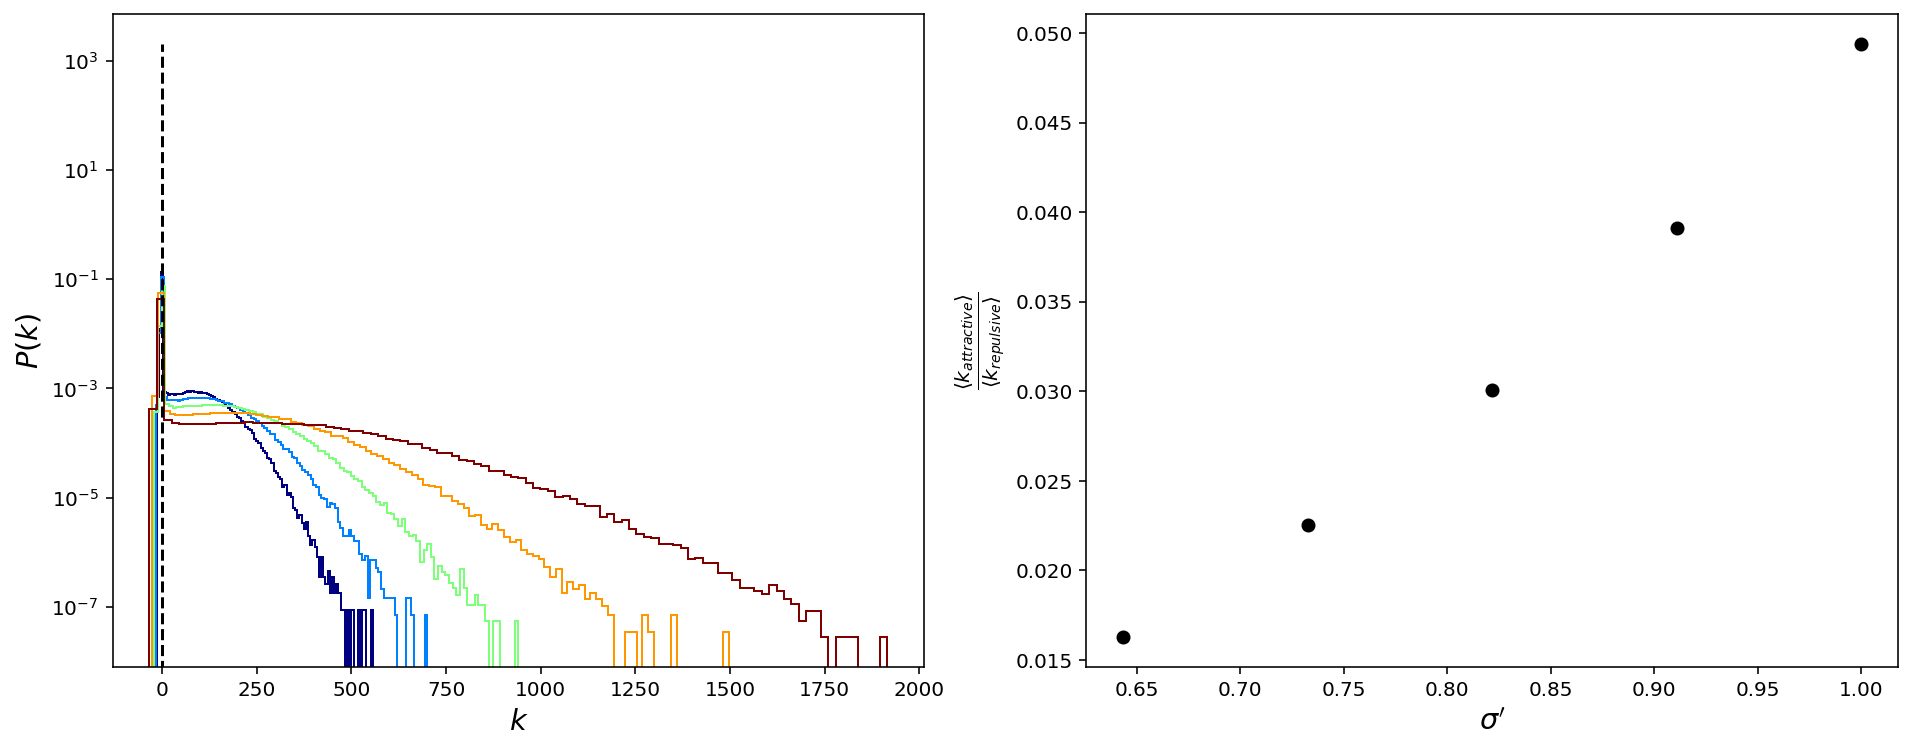

In [133]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

cmap = cm.jet
norm = colors.Normalize(vmin=0, vmax=0.4)
data = []
deltas = []
for delta, jobs_iter in project.find_jobs(None, {"_CRYSTAL": {"$exists": False}}).groupby("delta"):
    job = jobs_iter.__next__()
    for file in sorted(glob.glob(job.fn("short_runs/temp-*/fire_traj.gsd")))[2:3]:
        traj = gsd.hoomd.open(file)
        snap = traj[0]
        typeid = snap.particles.typeid
        position = snap.particles.position
        nlist_query = freud.locality.AABBQuery.from_system(snap)
        nlist = nlist_query.query(position[typeid == 0], {"r_min": 0.1, "r_max": 2.5}).toNeighborList()
        forces = np.zeros_like(nlist.distances)
        # energies = np.zeros_like(nlist.distances)
        # plt.sca(axs[0])
        # cond = typeid[nlist.point_indices] == 0
        # forces[cond] = mlj_force(nlist.distances[cond], delta)#*nlist.distances[cond]
        # cond = typeid[nlist.point_indices] == 1
        # forces[cond] = mlj_force(nlist.distances[cond], delta, epsilon=1.5, sigma=0.8)#*nlist.distances[cond]
        # plt.hist(forces, bins=100, histtype="step", density=True, label=f"{delta:.1f}", color=cmap(norm(delta)))
        # plt.sca(axs[1])
        # plt.plot((1-delta/2**(1/6)), -np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]), "ok")

        plt.sca(axs[0])
        cond = typeid[nlist.point_indices] == 0
        forces[cond] = mlj_stiffness(nlist.distances[cond], delta)#*nlist.distances[cond]
        cond = typeid[nlist.point_indices] == 1
        forces[cond] = mlj_stiffness(nlist.distances[cond], delta, epsilon=1.5, sigma=0.8)#*nlist.distances[cond]
        plt.hist(forces, bins=100, histtype="step", density=True, label=f"{delta:.1f}", color=cmap(norm(delta)))
        plt.sca(axs[1])
        plt.plot((1-delta/2**(1/6)), -np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]), "ok")
        data.append(-np.sum(forces[forces < 0.0])/np.sum(forces[forces > 0.0]))
        deltas.append((1-delta/2**(1/6)))
plt.sca(axs[0])
plt.yscale('log')
# plt.xscale('log')
lims = plt.xlim()
plt.vlines(0.0, *lims, "k", linestyles="dashed")
plt.xlabel(r"$k$")
plt.ylabel(r"$P(k)$")

plt.sca(axs[1])
plt.xlabel(r"$\sigma'$")
plt.ylabel(r"$\frac{\langle k_{attractive} \rangle}{\langle k_{repulsive} \rangle}$")
# plt.yscale('log')
# plt.xscale('log')
plt.savefig("cage-stiffness-sup.png", dpi=200)

params = np.polyfit(deltas, data, 1)

np.save(project.fn("structure/cage-stiffness-sup.npy"), np.array(data))

In [134]:
params

array([ 0.09297831, -0.04493584])

In [53]:
traj[0].particles.position.shape

(32768, 3)

In [57]:
np.sum()

In [63]:
cond = typeid[nlist.point_indices] == 0
forces[cond] = mlj_force(nlist.distances[cond], delta)
cond = typeid[nlist.point_indices] == 1
forces[cond] = mlj_force(nlist.distances[cond], delta, epsilon=1.5, sigma=0.8)

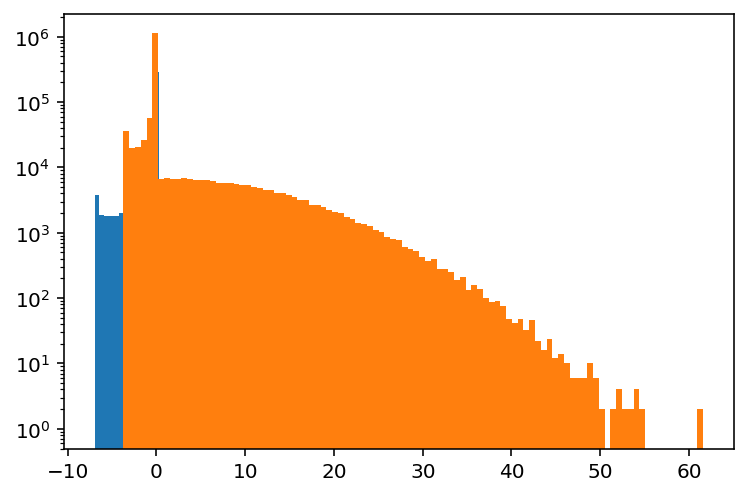

In [77]:
plt.hist(forces[cond], bins=100)
plt.hist(forces[typeid[nlist.point_indices] == 0], bins=100)
plt.yscale('log')